<a href="https://colab.research.google.com/github/jonasd4/pathology-worked-through/blob/main/cancer_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Worked-Through Example: Cancer classification from images**

This is the code for the first worked-through example: **Cancer classification from images** in our paper *Explainable AI for Precision Pathology*. We will train a model to classify different colorectal patches into tissue classes. The tissue classes are: Adipose (ADI), background (BACK), debris (DEB), lymphocytes (LYM), mucus (MUC), smooth muscle (MUS), normal colon mucosa (NORM), cancer-associated stroma (STR), colorectal adenocarcinoma epithelium (TUM).

In [ ]:
# Clone the repository with the code
!git clone https://github.com/jonasd4/pathology-worked-through

In [4]:
# Imports
import matplotlib.pyplot as plt
from PIL import Image
import os
import random

After cloning the repository, we need to download the patch dataset which we want to investigate. The original dataset was published by the authors on [Zenodo](https://zenodo.org/record/1214456#.Y_nbuuzMK3J). To speed up the download process, we download a copy from a Google Drive.

In [ ]:
## Download data
!wget --load-cookies /tmp/cookies.txt "https://docs.google.com/uc?export=download&confirm=$(wget --quiet --save-cookies /tmp/cookies.txt --keep-session-cookies --no-check-certificate 'https://docs.google.com/uc?export=download&id=1HSANsreKw3sxU7-dLr7c6_5ovexb6LR3' -O- | sed -rn 's/.*confirm=([0-9A-Za-z_]+).*/\1\n/p')&id=1HSANsreKw3sxU7-dLr7c6_5ovexb6LR3" -O CRC-VAL-HE-7K.zip && rm -rf /tmp/cookies.txt
!wget --load-cookies /tmp/cookies.txt "https://docs.google.com/uc?export=download&confirm=$(wget --quiet --save-cookies /tmp/cookies.txt --keep-session-cookies --no-check-certificate 'https://docs.google.com/uc?export=download&id=14SHepFBNGhNlGhncoT2bvTy5iNkgw9iT' -O- | sed -rn 's/.*confirm=([0-9A-Za-z_]+).*/\1\n/p')&id=14SHepFBNGhNlGhncoT2bvTy5iNkgw9iT" -O NCT-CRC-HE-100K-NONORM.zip && rm -rf /tmp/cookies.txt
!unzip CRC-VAL-HE-7K.zip
!unzip NCT-CRC-HE-100K-NONORM.zip

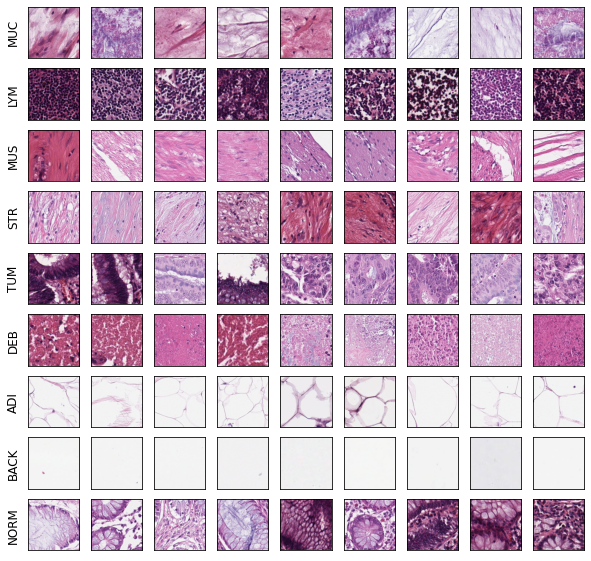

In [11]:
# Show example images from the dataset

path = 'NCT-CRC-HE-100K-NONORM'
classes = list(os.listdir(path))
samples_per_class = 9

fig, ax = plt.subplots(len(classes), samples_per_class)
fig.set_size_inches((10, 10))
for row_idx, cls in enumerate(classes):
  files = os.listdir(os.path.join(path, cls))
  random.shuffle(files)
  for col_idx, file in enumerate(files[:samples_per_class]):
    img = Image.open(os.path.join(path, cls, file))
    ax[row_idx][col_idx].imshow(img)
    ax[row_idx][col_idx].set_yticklabels([])
    ax[row_idx][col_idx].set_xticklabels([])
    ax[row_idx][col_idx].set_xticks([])
    ax[row_idx][col_idx].set_yticks([])
    ax[row_idx][0].set_ylabel(cls, rotation=90, size='large')

## Split the data
We now split the data into a train, test and validation split. The trainin set  will be 50% of the images and the validation and test set each 25%.

## Train the model
We will now train the model. We use Pytorch and [Pytorch Lightning](https://pytorch-lightning.readthedocs.io/en/stable/) to train our model. The training takes about 1 hour. To continue right away, you can also downlaod the trained model immediately below and follow the rest of the worked-through example.


## Evaluate

## Investigate the model with XAI

## Look at the color spectrum of the images

## Stain normalization

## Train the improved model